## FAQs: Causal Language Modeling

Dataset Source: FAQs From Large Transportation Company

#### Import Necessary Files

In [19]:
import os, sys, random, math

import pandas as pd

import matplotlib.pyplot as plt

import datasets
from datasets import Dataset

import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM, DataCollatorForLanguageModeling
from transformers import TrainingArguments, Trainer, set_seed

!git lfs install

Git LFS initialized.


#### Display Library Versions

In [20]:
print("Python:".rjust(15), sys.version[0:6])
print("Pandas:".rjust(15), pd.__version__)
print("Datasets:".rjust(15), datasets.__version__)
print("Transformers:".rjust(15), transformers.__version__)

        Python: 3.9.12
        Pandas: 1.5.0
      Datasets: 2.9.0
  Transformers: 4.26.1


#### Load Dataset

In [21]:
data_file = "Company FAQs.csv"

data = pd.read_csv(data_file, usecols=[0,1])

data = data.rename(columns={"question": "Question"})

data['input'] = "Question: " + data['Question'] + " Answer: " + data['Answer']

data['input_len'] = data['input'].str.len()

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Question   45 non-null     object
 1   Answer     45 non-null     object
 2   input      45 non-null     object
 3   input_len  45 non-null     int64 
dtypes: int64(1), object(3)
memory usage: 1.5+ KB


#### Visual: Histogram of Input Lengths

The maximum length of this dataset is approximately 5323 characters.


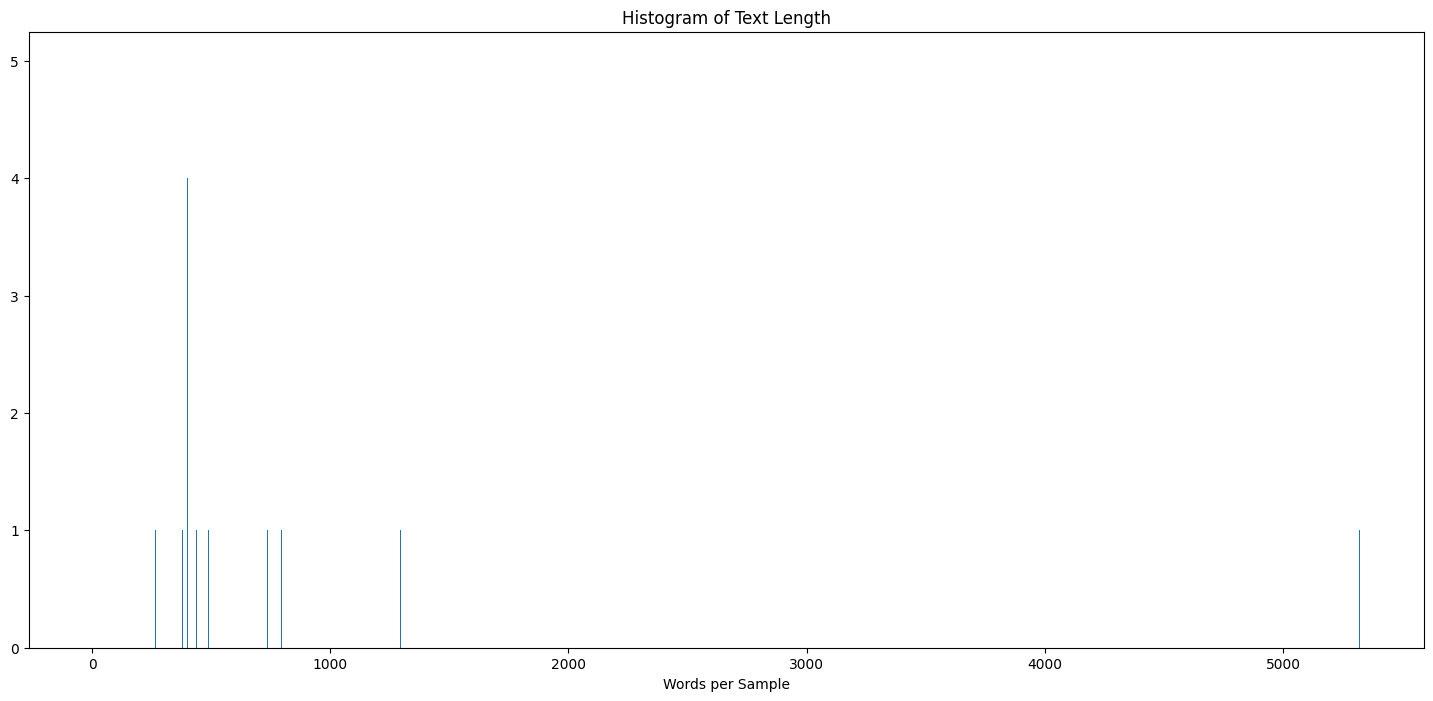

In [22]:
max_len = max(data['input_len'])

print(f"The maximum length of this dataset is approximately {max_len} characters.")

n = max_len
data.hist("input_len", grid=False, figsize=(18,8), range=(0, n + 1), bins=n + 1)
plt.suptitle('')
plt.title('Histogram of Text Length')
plt.ylabel('')
plt.xlabel('Words per Sample')
plt.show()

#### Trim Overly Lengthy Inputs

In [23]:
data = data.drop(columns=["input_len", "Question", "Answer"])


data

,input
0,Question: How can I talk to a real person? Ans...
1,Question: How do I contact customer service? A...
2,Question: How do I file a complaint? Answer: W...
3,Question: How to file a complaint? Answer: You...
4,Question: What do I do if my package was damag...
5,Question: How can I pay my bill? Answer: You h...
6,Question: How can I get help with my bill? Ans...
7,Question: What do I do if I’m locked out of my...
8,Question: Did You Know? Answer: Did you know? ...
9,Question: How do I find out my account number?...


#### Convert DataFrame to Dataset

In [24]:
ds = Dataset.from_pandas(data)

ds

Dataset({
    features: ['input'],
    num_rows: 45
})

#### Basic Values/Constants

In [25]:
BLOCK_SIZE = 128
MODEL_CKPT = "microsoft/DialoGPT-medium"

MODEL_NAME = MODEL_CKPT.split("/")[-1] + "-FAQs-Tuned"
set_seed = 42

BATCH_SIZE = 500 
NUM_OF_EPOCHS = 12

WEIGHT_DECAY = 0.01
STRATEGY = "epoch"

REPORTS_TO = "tensorboard"
LEARNING_RATE = 2e-5

print(MODEL_NAME)

DialoGPT-medium-FAQs-Tuned


#### Tokenize Entire Dataset

In [26]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_CKPT, use_fast=True)

def tokenizer_function(samples):
    return tokenizer(samples["input"])

A Jupyter Widget

A Jupyter Widget

loading configuration file config.json from cache at /Users/briandunn/.cache/huggingface/hub/models--microsoft--DialoGPT-medium/snapshots/9d5c5fadcc072b693fb5a5e29416bbf3f503c26c/config.json
Model config GPT2Config {
  "_name_or_path": "microsoft/DialoGPT-medium",
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 1024,
  "n_head": 16,
  "n_inner": null,
  "n_layer": 24,
  "n_positions": 1024,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "conversational": {
      "max_length": 1000


A Jupyter Widget

A Jupyter Widget

loading file vocab.json from cache at /Users/briandunn/.cache/huggingface/hub/models--microsoft--DialoGPT-medium/snapshots/9d5c5fadcc072b693fb5a5e29416bbf3f503c26c/vocab.json
loading file merges.txt from cache at /Users/briandunn/.cache/huggingface/hub/models--microsoft--DialoGPT-medium/snapshots/9d5c5fadcc072b693fb5a5e29416bbf3f503c26c/merges.txt
loading file tokenizer.json from cache at None
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /Users/briandunn/.cache/huggingface/hub/models--microsoft--DialoGPT-medium/snapshots/9d5c5fadcc072b693fb5a5e29416bbf3f503c26c/tokenizer_config.json
loading configuration file config.json from cache at /Users/briandunn/.cache/huggingface/hub/models--microsoft--DialoGPT-medium/snapshots/9d5c5fadcc072b693fb5a5e29416bbf3f503c26c/config.json
Model config GPT2Config {
  "_name_or_path": "microsoft/DialoGPT-medium",
  "activation_function": "gelu_new"

#### Apply Tokenizer Function to Entire Dataset

In [27]:
tokenized_ds = ds.map(tokenizer_function, 
                      batched=True,
                      remove_columns=ds.column_names,)

tokenized_ds

A Jupyter Widget

Token indices sequence length is longer than the specified maximum sequence length for this model (1839 > 1024). Running this sequence through the model will result in indexing errors


Dataset({
    features: ['input_ids', 'attention_mask'],
    num_rows: 45
})

#### Preprocess Tokenized Dataset

In [28]:
def group_texts(samples):
    # Concatenate all text
    concatenated_examples = {k: sum(samples[k], []) for k in samples.keys()}
    
    # Determine length of all text's concatenated
    total_length = len(concatenated_examples[list(samples.keys())[0]])
    
    # Determine number of blocks
    total_length = (total_length // BLOCK_SIZE) * BLOCK_SIZE
    
    # Split text into chunks of block_size
    result = {
        k: [t[i : i + BLOCK_SIZE] for i in range(0, total_length, BLOCK_SIZE)]
        for k, t in concatenated_examples.items()
    }
    result["labels"] = result["input_ids"].copy()
    return result

#### Apply Preprocessing Function to Dataset

In [29]:
clm_ds = tokenized_ds.map(
    group_texts,
    batched=True,
    num_proc=4,
)

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

#### Instantiate Model

In [30]:
model = AutoModelForCausalLM.from_pretrained(MODEL_CKPT)

loading configuration file config.json from cache at /Users/briandunn/.cache/huggingface/hub/models--microsoft--DialoGPT-medium/snapshots/9d5c5fadcc072b693fb5a5e29416bbf3f503c26c/config.json
Model config GPT2Config {
  "_name_or_path": "microsoft/DialoGPT-medium",
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 1024,
  "n_head": 16,
  "n_inner": null,
  "n_layer": 24,
  "n_positions": 1024,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "conversational": {
      "max_length": 1000


A Jupyter Widget

loading weights file pytorch_model.bin from cache at /Users/briandunn/.cache/huggingface/hub/models--microsoft--DialoGPT-medium/snapshots/9d5c5fadcc072b693fb5a5e29416bbf3f503c26c/pytorch_model.bin
Generate config GenerationConfig {
  "bos_token_id": 50256,
  "eos_token_id": 50256,
  "transformers_version": "4.26.1"
}

All model checkpoint weights were used when initializing GPT2LMHeadModel.

All the weights of GPT2LMHeadModel were initialized from the model checkpoint at microsoft/DialoGPT-medium.
If your task is similar to the task the model of the checkpoint was trained on, you can already use GPT2LMHeadModel for predictions without further training.


A Jupyter Widget

loading configuration file generation_config.json from cache at /Users/briandunn/.cache/huggingface/hub/models--microsoft--DialoGPT-medium/snapshots/9d5c5fadcc072b693fb5a5e29416bbf3f503c26c/generation_config.json
Generate config GenerationConfig {
  "_from_model_config": true,
  "bos_token_id": 50256,
  "eos_token_id": 50256,
  "transformers_version": "4.26.1"
}



#### Define TrainingArguments

In [31]:
args = TrainingArguments(
    output_dir=MODEL_NAME,
    evaluation_strategy=STRATEGY,
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    num_train_epochs=NUM_OF_EPOCHS,
    report_to=REPORTS_TO,
    logging_first_step=True,
    logging_strategy="steps",
    logging_steps=11,
    save_strategy=STRATEGY,
    hub_private_repo=True,
    push_to_hub=True
)

PyTorch: setting up devices


#### Define Data Collator

In [32]:
tokenizer.pad_token = tokenizer.eos_token
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

#### Instantiate Trainer

In [33]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=clm_ds,
    eval_dataset=clm_ds,
    data_collator=data_collator
)

Cloning https://huggingface.co/DunnBC22/DialoGPT-medium-FAQs-Tuned into local empty directory.


#### Train Model

In [34]:
train_results = trainer.train()

/Users/briandunn/Documents/nlpnn/nlp_ml/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 85
  Num Epochs = 12
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 132
  Number of trainable parameters = 354823168


A Jupyter Widget

You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'loss': 8.1467, 'learning_rate': 1.984848484848485e-05, 'epoch': 0.09}


***** Running Evaluation *****
  Num examples = 85
  Batch size = 8


{'loss': 6.2671, 'learning_rate': 1.8333333333333333e-05, 'epoch': 1.0}


A Jupyter Widget

Saving model checkpoint to DialoGPT-medium-FAQs-Tuned/checkpoint-11
Configuration saved in DialoGPT-medium-FAQs-Tuned/checkpoint-11/config.json
Configuration saved in DialoGPT-medium-FAQs-Tuned/checkpoint-11/generation_config.json


{'eval_loss': 4.803851127624512, 'eval_runtime': 201.1259, 'eval_samples_per_second': 0.423, 'eval_steps_per_second': 0.055, 'epoch': 1.0}


Model weights saved in DialoGPT-medium-FAQs-Tuned/checkpoint-11/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 85
  Batch size = 8


{'loss': 4.8143, 'learning_rate': 1.6666666666666667e-05, 'epoch': 2.0}


A Jupyter Widget

Saving model checkpoint to DialoGPT-medium-FAQs-Tuned/checkpoint-22
Configuration saved in DialoGPT-medium-FAQs-Tuned/checkpoint-22/config.json
Configuration saved in DialoGPT-medium-FAQs-Tuned/checkpoint-22/generation_config.json


{'eval_loss': 4.026591777801514, 'eval_runtime': 210.6257, 'eval_samples_per_second': 0.404, 'eval_steps_per_second': 0.052, 'epoch': 2.0}


Model weights saved in DialoGPT-medium-FAQs-Tuned/checkpoint-22/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 85
  Batch size = 8


{'loss': 4.072, 'learning_rate': 1.5000000000000002e-05, 'epoch': 3.0}


A Jupyter Widget

Saving model checkpoint to DialoGPT-medium-FAQs-Tuned/checkpoint-33
Configuration saved in DialoGPT-medium-FAQs-Tuned/checkpoint-33/config.json
Configuration saved in DialoGPT-medium-FAQs-Tuned/checkpoint-33/generation_config.json


{'eval_loss': 3.4453070163726807, 'eval_runtime': 209.7368, 'eval_samples_per_second': 0.405, 'eval_steps_per_second': 0.052, 'epoch': 3.0}


Model weights saved in DialoGPT-medium-FAQs-Tuned/checkpoint-33/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 85
  Batch size = 8


{'loss': 3.5482, 'learning_rate': 1.3333333333333333e-05, 'epoch': 4.0}


A Jupyter Widget

Saving model checkpoint to DialoGPT-medium-FAQs-Tuned/checkpoint-44
Configuration saved in DialoGPT-medium-FAQs-Tuned/checkpoint-44/config.json
Configuration saved in DialoGPT-medium-FAQs-Tuned/checkpoint-44/generation_config.json


{'eval_loss': 3.0559096336364746, 'eval_runtime': 203.0742, 'eval_samples_per_second': 0.419, 'eval_steps_per_second': 0.054, 'epoch': 4.0}


Model weights saved in DialoGPT-medium-FAQs-Tuned/checkpoint-44/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 85
  Batch size = 8


{'loss': 3.2654, 'learning_rate': 1.1666666666666668e-05, 'epoch': 5.0}


A Jupyter Widget

Saving model checkpoint to DialoGPT-medium-FAQs-Tuned/checkpoint-55
Configuration saved in DialoGPT-medium-FAQs-Tuned/checkpoint-55/config.json
Configuration saved in DialoGPT-medium-FAQs-Tuned/checkpoint-55/generation_config.json


{'eval_loss': 2.815948486328125, 'eval_runtime': 196.9651, 'eval_samples_per_second': 0.432, 'eval_steps_per_second': 0.056, 'epoch': 5.0}


Model weights saved in DialoGPT-medium-FAQs-Tuned/checkpoint-55/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 85
  Batch size = 8


{'loss': 2.9732, 'learning_rate': 1e-05, 'epoch': 6.0}


A Jupyter Widget

Saving model checkpoint to DialoGPT-medium-FAQs-Tuned/checkpoint-66
Configuration saved in DialoGPT-medium-FAQs-Tuned/checkpoint-66/config.json
Configuration saved in DialoGPT-medium-FAQs-Tuned/checkpoint-66/generation_config.json


{'eval_loss': 2.597230911254883, 'eval_runtime': 197.0769, 'eval_samples_per_second': 0.431, 'eval_steps_per_second': 0.056, 'epoch': 6.0}


Model weights saved in DialoGPT-medium-FAQs-Tuned/checkpoint-66/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 85
  Batch size = 8


{'loss': 2.8302, 'learning_rate': 8.333333333333334e-06, 'epoch': 7.0}


A Jupyter Widget

Saving model checkpoint to DialoGPT-medium-FAQs-Tuned/checkpoint-77
Configuration saved in DialoGPT-medium-FAQs-Tuned/checkpoint-77/config.json
Configuration saved in DialoGPT-medium-FAQs-Tuned/checkpoint-77/generation_config.json


{'eval_loss': 2.4588348865509033, 'eval_runtime': 196.3558, 'eval_samples_per_second': 0.433, 'eval_steps_per_second': 0.056, 'epoch': 7.0}


Model weights saved in DialoGPT-medium-FAQs-Tuned/checkpoint-77/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 85
  Batch size = 8


{'loss': 2.6841, 'learning_rate': 6.666666666666667e-06, 'epoch': 8.0}


A Jupyter Widget

Saving model checkpoint to DialoGPT-medium-FAQs-Tuned/checkpoint-88
Configuration saved in DialoGPT-medium-FAQs-Tuned/checkpoint-88/config.json
Configuration saved in DialoGPT-medium-FAQs-Tuned/checkpoint-88/generation_config.json


{'eval_loss': 2.337815284729004, 'eval_runtime': 196.5914, 'eval_samples_per_second': 0.432, 'eval_steps_per_second': 0.056, 'epoch': 8.0}


Model weights saved in DialoGPT-medium-FAQs-Tuned/checkpoint-88/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 85
  Batch size = 8


{'loss': 2.5855, 'learning_rate': 5e-06, 'epoch': 9.0}


A Jupyter Widget

Saving model checkpoint to DialoGPT-medium-FAQs-Tuned/checkpoint-99
Configuration saved in DialoGPT-medium-FAQs-Tuned/checkpoint-99/config.json
Configuration saved in DialoGPT-medium-FAQs-Tuned/checkpoint-99/generation_config.json


{'eval_loss': 2.2652175426483154, 'eval_runtime': 198.2924, 'eval_samples_per_second': 0.429, 'eval_steps_per_second': 0.055, 'epoch': 9.0}


Model weights saved in DialoGPT-medium-FAQs-Tuned/checkpoint-99/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 85
  Batch size = 8


{'loss': 2.5088, 'learning_rate': 3.3333333333333333e-06, 'epoch': 10.0}


A Jupyter Widget

Saving model checkpoint to DialoGPT-medium-FAQs-Tuned/checkpoint-110
Configuration saved in DialoGPT-medium-FAQs-Tuned/checkpoint-110/config.json
Configuration saved in DialoGPT-medium-FAQs-Tuned/checkpoint-110/generation_config.json


{'eval_loss': 2.2036728858947754, 'eval_runtime': 197.3854, 'eval_samples_per_second': 0.431, 'eval_steps_per_second': 0.056, 'epoch': 10.0}


Model weights saved in DialoGPT-medium-FAQs-Tuned/checkpoint-110/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 85
  Batch size = 8


{'loss': 2.4637, 'learning_rate': 1.6666666666666667e-06, 'epoch': 11.0}


A Jupyter Widget

Saving model checkpoint to DialoGPT-medium-FAQs-Tuned/checkpoint-121
Configuration saved in DialoGPT-medium-FAQs-Tuned/checkpoint-121/config.json
Configuration saved in DialoGPT-medium-FAQs-Tuned/checkpoint-121/generation_config.json


{'eval_loss': 2.170647382736206, 'eval_runtime': 203.0223, 'eval_samples_per_second': 0.419, 'eval_steps_per_second': 0.054, 'epoch': 11.0}


Model weights saved in DialoGPT-medium-FAQs-Tuned/checkpoint-121/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 85
  Batch size = 8


{'loss': 2.4402, 'learning_rate': 0.0, 'epoch': 12.0}


A Jupyter Widget

Saving model checkpoint to DialoGPT-medium-FAQs-Tuned/checkpoint-132
Configuration saved in DialoGPT-medium-FAQs-Tuned/checkpoint-132/config.json
Configuration saved in DialoGPT-medium-FAQs-Tuned/checkpoint-132/generation_config.json


{'eval_loss': 2.160059928894043, 'eval_runtime': 199.1187, 'eval_samples_per_second': 0.427, 'eval_steps_per_second': 0.055, 'epoch': 12.0}


Model weights saved in DialoGPT-medium-FAQs-Tuned/checkpoint-132/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)




{'train_runtime': 10171.3234, 'train_samples_per_second': 0.1, 'train_steps_per_second': 0.013, 'train_loss': 3.385300874710083, 'epoch': 12.0}


#### Evaluate Model

In [35]:
evaluation_results = trainer.evaluate()
print(f"Perplexity: {math.exp(evaluation_results['eval_loss']):.2f}")

***** Running Evaluation *****
  Num examples = 85
  Batch size = 8


A Jupyter Widget

Perplexity: 8.67


#### Push Model to HuggingFace Hub

In [36]:
trainer.push_to_hub()

Saving model checkpoint to DialoGPT-medium-FAQs-Tuned
Configuration saved in DialoGPT-medium-FAQs-Tuned/config.json
Configuration saved in DialoGPT-medium-FAQs-Tuned/generation_config.json
Model weights saved in DialoGPT-medium-FAQs-Tuned/pytorch_model.bin
Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

To https://huggingface.co/DunnBC22/DialoGPT-medium-FAQs-Tuned
   9ac1e66..44c500f  main -> main

Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Causal Language Modeling', 'type': 'text-generation'}}
Adding files tracked by Git LFS: ['.DS_Store']. This may take a bit of time if the files are large.


A Jupyter Widget

A Jupyter Widget

To https://huggingface.co/DunnBC22/DialoGPT-medium-FAQs-Tuned
   44c500f..a3a521a  main -> main



'https://huggingface.co/DunnBC22/DialoGPT-medium-FAQs-Tuned/commit/44c500f72c2501f604f8a5d5542296bbdf9ee5f5'

### Notes & Other Key Takeaways
****
- Training this model on the Frequently Asked Questions for a different company or department would create a fantastic way to automate some mundane and easily answered questions.
- With a perplexity value of 8.67, this model is well suited already, but I want to try training it with the larger version of this transformer to see if there is substanital improvement.
****